In [130]:
import os
import pandas as pd

from galaxy_datasets.shared import label_metadata

- Path tinkering: add galahad locs, optionally use rsync to download from galahad
- Add in the GZ DESI volunteer vote columns and ML predictions
- Add in the GZ2 volunteer votes



In [131]:
df = pd.read_csv('data/gz3d_and_gz_desi_matches.csv')

In [132]:
#  '/share/nas2/walml/galaxy_zoo/decals/dr8/fits/'
df['galahad_fits_loc'] = df['brickid'].astype(str) + '/' + df['brickid'].astype(str) + '_' + df['objid'].astype(str) + '.fits'


#  '/share/nas2/walml/galaxy_zoo/decals/dr8/jpg/'
df['galahad_jpg_loc'] = df['brickid'].astype(str) + '/' + df['brickid'].astype(str) + '_' + df['objid'].astype(str) + '.jpg'

df['galahad_fits_loc'][0], df['galahad_jpg_loc'][0]

('593252/593252_2670.fits', '593252/593252_2670.jpg')

In [133]:
# df['dr8_id'].value_counts()
# TODO drop duplicate matches, temporarily
df = df.drop_duplicates(subset='dr8_id', keep=False)

In [134]:
# with open('data/galahad_fits_to_copy.txt', 'w') as f:
#     f.write('\n'.join(df['galahad_fits_loc']))

# with open('data/galahad_jpg_to_copy.txt', 'w') as f:
#     f.write('\n'.join(df['galahad_jpg_loc']))

In [135]:
# rsync --files-from data/galahad_fits_to_copy.txt -e 'ssh -A -J walml@external.jb.man.ac.uk' walml@galahad.ast.man.ac.uk:/share/nas2/walml/galaxy_zoo/decals/dr8/fits data/gz_desi/fits

In [136]:
# rsync --files-from data/galahad_jpg_to_copy.txt -e 'ssh -A -J walml@external.jb.man.ac.uk' walml@galahad.ast.man.ac.uk:/share/nas2/walml/galaxy_zoo/decals/dr8/jpg data/gz_desi/jpg

In [137]:
df['relative_desi_fits_loc'] = 'data/desi/fits/' + df['brickid'].astype(str) + '/' + df['brickid'].astype(str) + '_' + df['objid'].astype(str) + '.fits'
df['relative_desi_jpg_loc'] = 'data/desi/jpg/' + df['brickid'].astype(str) + '/' + df['brickid'].astype(str) + '_' + df['objid'].astype(str) + '.jpg'

In [138]:
df['relative_segmap_json_loc'] = df['relative_gz3d_fits_loc'].str.replace('/fits_gz/', '/segmaps/marks/', regex=False).str.replace('.fits.gz', '.json', regex=False)

In [139]:
df['relative_spiral_mask_loc'] = df['relative_gz3d_fits_loc'].apply(lambda x: x.replace('/fits_gz/', '/segmaps/masks_constnorm/').replace('.fits.gz', '_spiral.jpg'))
df['relative_bar_mask_loc'] = df['relative_gz3d_fits_loc'].apply(lambda x: x.replace('/fits_gz/', '/segmaps/masks_constnorm/').replace('.fits.gz', '_bar.jpg'))

In [140]:
df['relative_spiral_mask_loc'][0]

'data/gz3d/segmaps/masks_constnorm/gz3d_1-379196_127_14728482_spiral.jpg'

In [141]:
len(df)

28983

In [142]:
df = df[df['relative_gz3d_fits_loc'].apply(lambda x: os.path.isfile(x))]
len(df)

28983

In [143]:
# add GZ DESI votes themselves

desi_vote_locs = [
    '/Volumes/beta/galaxy_zoo/decals/dr8/catalogs/training_catalogs/dr12_ortho_v5_labelled_catalog.parquet',
    '/Volumes/beta/galaxy_zoo/decals/dr8/catalogs/training_catalogs/dr5_ortho_v5_labelled_catalog.parquet',
    '/Volumes/beta/galaxy_zoo/decals/dr8/catalogs/training_catalogs/dr8_ortho_v5_labelled_catalog.parquet',
]

columns = [
    'dr8_id',
] + label_metadata.decals_all_campaigns_ortho_label_cols
gz_desi_votes = pd.concat([pd.read_parquet(loc, columns=columns) for loc in desi_vote_locs])

df = pd.merge(df, gz_desi_votes, on='dr8_id', validate='one_to_one', how='outer')
# left, because some have no votes (about half, 14k of 29k have votes)
# now outer, because we want to learn to classify as usual
df[label_metadata.decals_all_campaigns_ortho_label_cols] = df[label_metadata.decals_all_campaigns_ortho_label_cols].fillna(0)



In [144]:
# add GZ DESI vote predictions (just for filtering)

columns = [
    'dr8_id',
    'ra',  # from desi master catalog
    'dec',
    'smooth-or-featured_featured-or-disk_fraction',
    'disk-edge-on_yes_fraction',
    'has-spiral-arms_yes_fraction',
    'spiral-arm-count_2_fraction'
]
gz_desi_preds = pd.read_parquet(
    '/Users/user/repos/desi-predictions/results/final/gz_desi_deep_learning_catalog_advanced.parquet',
    columns=columns
)

In [145]:
gz_desi_preds['brickid'] = gz_desi_preds['dr8_id'].apply(lambda x: x.split('_')[0])
gz_desi_preds['objid'] = gz_desi_preds['dr8_id'].apply(lambda x: x.split('_')[1])


In [146]:
df['dr8_id'].value_counts()

593252_2670    1
478644_956     1
336244_562     1
394180_4638    1
372574_3300    1
              ..
405238_4374    1
392674_1727    1
420077_1742    1
402523_1172    1
164230_2200    1
Name: dr8_id, Length: 415591, dtype: int64

In [147]:
del df['brickid']
del df['objid']
df = pd.merge(df, gz_desi_preds, on='dr8_id', validate='one_to_one', how='inner')

In [148]:
df['smooth-or-featured_featured-or-disk_fraction'].isna().sum(), df['brickid'].isna().sum()

(0, 0)

In [149]:
len(df)

415591

In [150]:
df['galahad_jpg_loc'] = '/share/nas2/walml/galaxy_zoo/decals/dr8/jpg/' + df['brickid'].astype(str) + '/' + df['brickid'].astype(str) + '_' + df['objid'].astype(str) + '.jpg'
df['galahad_jpg_loc'].iloc[0]

'/share/nas2/walml/galaxy_zoo/decals/dr8/jpg/593252/593252_2670.jpg'

In [151]:
df['relative_spiral_mask_loc'] = df['relative_spiral_mask_loc'].fillna('')
df['relative_bar_mask_loc'] = df['relative_bar_mask_loc'].fillna('')

In [152]:
((df['relative_spiral_mask_loc'].str.startswith('data/gz3d/segmaps/masks/')) | (df['relative_spiral_mask_loc'] == '')).mean()

0.930260761181065

In [153]:
df['relative_spiral_mask_loc'] = df['relative_spiral_mask_loc'].astype(str)
df['relative_bar_mask_loc'] = df['relative_bar_mask_loc'].astype(str)

In [154]:
# df.to_parquet('data/gz3d_and_gz_desi_master_catalog.parquet', index=False)

In [155]:
# df = pd.read_parquet('data/gz3d_and_gz_desi_master_catalog.parquet')

In [156]:
# merge in gz2 matches on dr8_id
gz2_desi_matches = pd.read_csv('/Users/user/repos/zoobot-3d/data/gz2_and_gz_desi_matches.csv')
gz2_desi_matches.columns.values


array(['dr7objid', 'ra_gz2', 'dec_gz2', 'smooth-or-featured-gz2_smooth',
       'smooth-or-featured-gz2_featured-or-disk',
       'smooth-or-featured-gz2_artifact', 'disk-edge-on-gz2_yes',
       'disk-edge-on-gz2_no', 'bar-gz2_yes', 'bar-gz2_no',
       'has-spiral-arms-gz2_yes', 'has-spiral-arms-gz2_no',
       'bulge-size-gz2_no', 'bulge-size-gz2_just-noticeable',
       'bulge-size-gz2_obvious', 'bulge-size-gz2_dominant',
       'something-odd-gz2_yes', 'something-odd-gz2_no',
       'how-rounded-gz2_round', 'how-rounded-gz2_in-between',
       'how-rounded-gz2_cigar', 'bulge-shape-gz2_round',
       'bulge-shape-gz2_boxy', 'bulge-shape-gz2_no-bulge',
       'spiral-winding-gz2_tight', 'spiral-winding-gz2_medium',
       'spiral-winding-gz2_loose', 'spiral-arm-count-gz2_1',
       'spiral-arm-count-gz2_2', 'spiral-arm-count-gz2_3',
       'spiral-arm-count-gz2_4', 'spiral-arm-count-gz2_more-than-4',
       'spiral-arm-count-gz2_cant-tell',
       'smooth-or-featured-gz2_total-votes

In [157]:
gz2_cols = [col for col in gz2_desi_matches.columns.values if 'gz2' in col] + ['dr8_id']
df = pd.merge(df, gz2_desi_matches[gz2_cols], how='left', on='dr8_id')

In [158]:
df[label_metadata.gz2_ortho_label_cols] = df[label_metadata.gz2_ortho_label_cols].fillna(0)


In [159]:
df['smooth-or-featured-gz2_smooth']

0          0.0
1         36.0
2         31.0
3          0.0
4         22.0
          ... 
415597     0.0
415598     0.0
415599     0.0
415600     0.0
415601     0.0
Name: smooth-or-featured-gz2_smooth, Length: 415602, dtype: float64

In [160]:
df.to_parquet('data/gz3d_and_desi_master_catalog.parquet', index=False)  # now with gz2 also

Sense check

In [161]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json

In [162]:
df.columns.values

array(['ra_manga', 'dec_manga', 'mangaid', 'iauname', 'ifudesignsize',
       'manga_tileid', 'nsa_id', 'explorer_link',
       'gz_total_classifications', 'gz_bar_votes', 'gz_spiral_votes',
       'sample', 'relative_gz3d_fits_loc', 'best_match', 'sky_separation',
       'ra_desi', 'dec_desi', 'dr8_id', 'mag_r', 'mag_g', 'mag_z',
       'est_dr5_pixscale', 'galahad_fits_loc', 'galahad_jpg_loc',
       'relative_desi_fits_loc', 'relative_desi_jpg_loc',
       'relative_segmap_json_loc', 'relative_spiral_mask_loc',
       'relative_bar_mask_loc', 'smooth-or-featured-dr12_smooth',
       'smooth-or-featured-dr12_featured-or-disk',
       'smooth-or-featured-dr12_artifact', 'disk-edge-on-dr12_yes',
       'disk-edge-on-dr12_no', 'has-spiral-arms-dr12_yes',
       'has-spiral-arms-dr12_no', 'bar-dr12_yes', 'bar-dr12_no',
       'bulge-size-dr12_dominant', 'bulge-size-dr12_obvious',
       'bulge-size-dr12_none', 'how-rounded-dr12_completely',
       'how-rounded-dr12_in-between', 'how-roun

In [163]:
df['relative_spiral_mask_loc']

0         data/gz3d/segmaps/masks_constnorm/gz3d_1-37919...
1         data/gz3d/segmaps/masks_constnorm/gz3d_1-12258...
2         data/gz3d/segmaps/masks_constnorm/gz3d_1-41308...
3         data/gz3d/segmaps/masks_constnorm/gz3d_1-37002...
4         data/gz3d/segmaps/masks_constnorm/gz3d_1-47213...
                                ...                        
415597                                                     
415598                                                     
415599                                                     
415600                                                     
415601                                                     
Name: relative_spiral_mask_loc, Length: 415602, dtype: object

In [164]:
df['spiral_mask_exists'] = df['relative_spiral_mask_loc'].apply(os.path.isfile)

In [165]:
df.query('spiral_mask_exists')[['gz_total_classifications', 'gz_spiral_votes', 'smooth-or-featured-dr5_featured-or-disk', 'smooth-or-featured_featured-or-disk_fraction']]

,gz_total_classifications,gz_spiral_votes,smooth-or-featured-dr5_featured-or-disk,smooth-or-featured_featured-or-disk_fraction
0,0.0,0.0,0.0,0.156200
9,0.0,0.0,0.0,0.229812
12,39.0,14.0,0.0,0.740266
28,0.0,0.0,0.0,0.415201
29,0.0,0.0,0.0,0.737831
32,34.0,13.0,0.0,0.914805
43,25.0,22.0,5.0,0.931651
48,38.0,25.0,0.0,0.932700
50,44.0,12.0,0.0,0.832121
53,39.0,12.0,0.0,0.856912


In [166]:
# example = df.query('spiral_mask_exists').iloc[0]
example = df.query('spiral_mask_exists').loc[108]

In [167]:
with open(example['relative_segmap_json_loc']) as f:
    example_json = json.load(f)
len(example_json['spiral_mask']), len([x for x in example_json['spiral_mask'] if len(x) > 0])

(15, 10)

In [168]:
Image.open(example['relative_desi_jpg_loc']).show()

In [169]:
Image.open(example['relative_spiral_mask_loc']).show()

In [170]:
example[[col for col in df.columns.values if 'dr5' in col]]

est_dr5_pixscale                           0.477153
smooth-or-featured-dr5_smooth                   1.0
smooth-or-featured-dr5_featured-or-disk        37.0
smooth-or-featured-dr5_artifact                 2.0
disk-edge-on-dr5_yes                            0.0
disk-edge-on-dr5_no                            37.0
has-spiral-arms-dr5_yes                        37.0
has-spiral-arms-dr5_no                          0.0
bar-dr5_strong                                  2.0
bar-dr5_weak                                    7.0
bar-dr5_no                                     28.0
bulge-size-dr5_dominant                         0.0
bulge-size-dr5_large                            0.0
bulge-size-dr5_moderate                         5.0
bulge-size-dr5_small                           28.0
bulge-size-dr5_none                             4.0
how-rounded-dr5_round                           1.0
how-rounded-dr5_in-between                      0.0
how-rounded-dr5_cigar-shaped                    0.0
edge-on-bulg

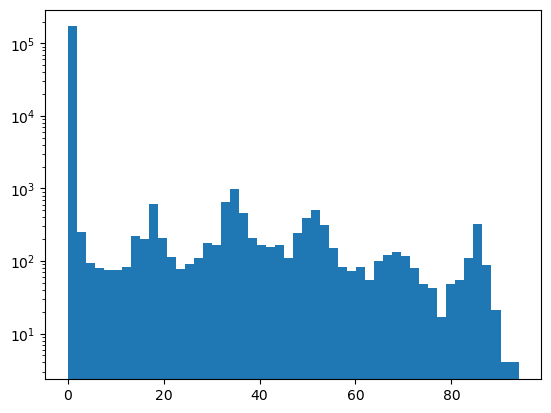

In [171]:
plt.hist(np.array(Image.open(example['relative_spiral_mask_loc'])).flatten(), bins=50)
plt.yscale('log')

In [172]:
np.array(Image.open(example['relative_spiral_mask_loc'])).max() * 15 / 255
# .show()

5.529411764705882

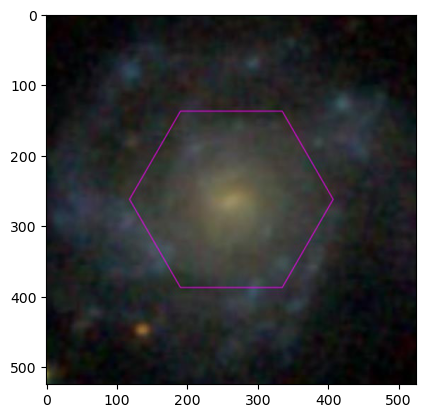

In [174]:
plt.imshow(fits.open(example['relative_gz3d_fits_loc'])[0].data)

(array([0.03579521, 0.29033892, 0.5249964 , 0.45340589, 0.34602042,
        0.35795202, 0.36789528, 0.395736  , 0.42954224, 0.47528093,
        0.50511027, 0.60454143, 0.59857556, 0.72783547, 0.80340309,
        0.96647162, 1.16334358, 1.27470638, 1.45965056, 2.00055323,
        2.14174884, 2.40623202, 2.9312281 , 3.52384303, 2.4877655 ]),
 array([0.03532363, 0.07199131, 0.10865899, 0.14532667, 0.18199436,
        0.21866204, 0.25532973, 0.2919974 , 0.32866508, 0.36533278,
        0.40200046, 0.43866813, 0.47533581, 0.51200348, 0.54867119,
        0.58533889, 0.62200654, 0.65867424, 0.69534194, 0.73200959,
        0.76867729, 0.80534494, 0.84201264, 0.87868035, 0.91534799,
        0.9520157 ]),
 [<matplotlib.patches.Polygon at 0x13e6d6280>])

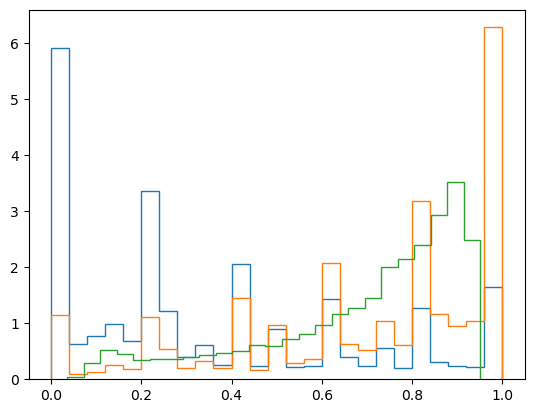

In [176]:
df['smooth-or-featured-dr5_total-votes'] = df['smooth-or-featured-dr5_smooth'] + df['smooth-or-featured-dr5_featured-or-disk'] + df['smooth-or-featured-dr5_artifact']
plt.hist(df['smooth-or-featured-dr5_featured-or-disk'] / df['smooth-or-featured-dr5_total-votes'], bins=25, density=True, histtype='step')
plt.hist(df.query('gz_spiral_votes > 0')['smooth-or-featured-dr5_featured-or-disk'] / df.query('gz_spiral_votes > 0')['smooth-or-featured-dr5_total-votes'], bins=25, density=True, histtype='step')
plt.hist(df.query('gz_spiral_votes > 0')['smooth-or-featured_featured-or-disk_fraction'], bins=25, density=True, histtype='step')

In [177]:
(df['smooth-or-featured-dr5_total-votes'] > 0).sum(), len(df)

(247395, 415602)

In [181]:
df.sample()[['dr8_id', 'ra', 'dec', 'ra_manga', 'dec_manga', 'ra_desi', 'dec_desi', 'smooth-or-featured_featured-or-disk_fraction']]  # checks out visually

,dr8_id,ra,dec,ra_manga,dec_manga,ra_desi,dec_desi,smooth-or-featured_featured-or-disk_fraction
282610,328951_7842,5.965594,-0.128487,NaN,NaN,NaN,NaN,0.917167


In [ ]:
df.columns.values

array(['ra_manga', 'dec_manga', 'mangaid', 'iauname', 'ifudesignsize',
       'manga_tileid', 'nsa_id', 'explorer_link',
       'gz_total_classifications', 'gz_bar_votes', 'gz_spiral_votes',
       'sample', 'relative_gz3d_fits_loc', 'best_match', 'sky_separation',
       'ra_desi', 'dec_desi', 'dr8_id', 'mag_r', 'mag_g', 'mag_z',
       'est_dr5_pixscale', 'galahad_fits_loc', 'galahad_jpg_loc',
       'relative_desi_fits_loc', 'relative_desi_jpg_loc',
       'relative_segmap_json_loc', 'relative_spiral_mask_loc',
       'relative_bar_mask_loc', 'smooth-or-featured-dr12_smooth',
       'smooth-or-featured-dr12_featured-or-disk',
       'smooth-or-featured-dr12_artifact', 'disk-edge-on-dr12_yes',
       'disk-edge-on-dr12_no', 'has-spiral-arms-dr12_yes',
       'has-spiral-arms-dr12_no', 'bar-dr12_yes', 'bar-dr12_no',
       'bulge-size-dr12_dominant', 'bulge-size-dr12_obvious',
       'bulge-size-dr12_none', 'how-rounded-dr12_completely',
       'how-rounded-dr12_in-between', 'how-roun